# A1. 
Write a function to calculate the entropy associated with your dataset. (If your dataset contains 
only continuous numeric data for outcome (a regression problem), employ equal width binning and 
divide your data into 4 bins. Each bin may be considered as a categorical data value. Write a function 
for equal width binning). 

In [9]:
import pandas as pd
import numpy as np

def func1(dataset):
    df = pd.read_csv(dataset)

    count = df['Species'].value_counts()
    probs = count/len(df)
    prob_ent = -np.sum(probs*np.log2(probs))
    return prob_ent

f1 = func1("Iris.csv")
print(f1)

1.584962500721156


# A2
Calculate the Gini index value for your dataset.

In [ ]:
def func2(dataset):
    df = pd.read_csv(dataset)
    count = df['Species'].value_counts()
    probs = count/len(df)
    op = np.sum(1-probs**2)
    return op

f = func2("Iris.csv")
print(f)

2.6666666666666665


# A3

Write your own module for detecting the feature / attribute for the root note of a Decision Tree. 
Use Information gain as the impurity measure for identifying the root node. Assume that the 
features are categorical or could be converted to categorical by binning.

In [11]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.preprocessing import KBinsDiscretizer

# ----------------------------
# Utility Functions
# ----------------------------

def entropy(y):
    """Compute entropy of a label distribution."""
    _, counts = np.unique(y, return_counts=True)
    probs = counts / counts.sum()
    return -np.sum(probs * np.log2(probs))

def information_gain(X_col, y):
    """Compute Information Gain of splitting on a given feature column."""
    # total entropy before split
    H_y = entropy(y)

    # values and counts for feature
    values, counts = np.unique(X_col, return_counts=True)
    weighted_entropy = 0

    for v, count in zip(values, counts):
        y_subset = y[X_col == v]
        weighted_entropy += (count / len(X_col)) * entropy(y_subset)

    return H_y - weighted_entropy

# ----------------------------
# Main Root Node Finder
# ----------------------------

def find_root_node(X, y, binning=True, n_bins=3):
    """
    Find root node feature for Decision Tree using Information Gain.
    
    Parameters:
        X : DataFrame
            Feature matrix
        y : array-like
            Labels
        binning : bool
            Whether to bin continuous features
        n_bins : int
            Number of bins if binning
    
    Returns:
        str : name of root feature
        dict : information gains for all features
    """

    X_copy = X.copy()
    
    # Bin numerical features into categories
    if binning:
        kb = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
        X_copy = pd.DataFrame(kb.fit_transform(X_copy), columns=X_copy.columns)

    # Compute IG for each feature
    ig_scores = {}
    for col in X_copy.columns:
        ig_scores[col] = information_gain(X_copy[col].values, y)

    # Select feature with max IG
    root_feature = max(ig_scores, key=ig_scores.get)
    return root_feature, ig_scores

# ----------------------------
# Example Usage with Iris
# ----------------------------
if __name__ == "__main__":
    iris = load_iris()
    X = pd.DataFrame(iris.data, columns=iris.feature_names)
    y = iris.target

    root, scores = find_root_node(X, y, binning=True, n_bins=3)

    print("Information Gain scores:", scores)
    print("Root node feature:", root)

Information Gain scores: {'sepal length (cm)': np.float64(0.6222602950552835), 'sepal width (cm)': np.float64(0.2658955550314974), 'petal length (cm)': np.float64(1.3246637751447135), 'petal width (cm)': np.float64(1.3693690649563948)}
Root node feature: petal width (cm)


A4. If the feature is continuous valued for A3, use equal width or frequency binning for converting 
the attribute to categorical valued. The binning type should be a parameter to the function built for 
binning. Write your own function for the binning task. The number of bins to be created should also 
be passed as a parameter to the function. Use function overloading to allow for usage of default 
parameters if no parameters are passed.


In [12]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris

# ----------------------------
# Utility Functions
# ----------------------------

def entropy(y):
    """Compute entropy of a label distribution."""
    _, counts = np.unique(y, return_counts=True)
    probs = counts / counts.sum()
    return -np.sum(probs * np.log2(probs))

def information_gain(X_col, y):
    """Compute Information Gain of splitting on a given feature column."""
    H_y = entropy(y)  # total entropy before split
    values, counts = np.unique(X_col, return_counts=True)
    
    weighted_entropy = 0
    for v, count in zip(values, counts):
        y_subset = y[X_col == v]
        weighted_entropy += (count / len(X_col)) * entropy(y_subset)

    return H_y - weighted_entropy


# ----------------------------
# Custom Binning Function
# ----------------------------

def custom_binning(column, n_bins=3, bin_type="width"):
    """
    Convert continuous column into categorical bins.
    
    Parameters:
        column : array-like
            Continuous values
        n_bins : int
            Number of bins
        bin_type : str
            "width" for equal-width binning
            "frequency" for equal-frequency binning
            
    Returns:
        binned_column : np.array
            Discretized categorical column
    """
    col = np.array(column)

    if bin_type == "width":
        # Equal-width binning
        bins = np.linspace(col.min(), col.max(), n_bins + 1)
    elif bin_type == "frequency":
        # Equal-frequency binning
        bins = np.percentile(col, np.linspace(0, 100, n_bins + 1))
    else:
        raise ValueError("bin_type must be 'width' or 'frequency'")

    # Digitize assigns bin numbers (1..n_bins)
    binned = np.digitize(col, bins, right=False) - 1
    binned[binned == n_bins] = n_bins - 1  # Fix edge case
    return binned


# ----------------------------
# Root Node Finder
# ----------------------------

def find_root_node(X, y, n_bins=3, bin_type="width"):
    """
    Find root node feature for Decision Tree using Information Gain.
    
    Parameters:
        X : DataFrame
            Feature matrix
        y : array-like
            Labels
        n_bins : int, default=3
            Number of bins
        bin_type : str, default="width"
            Binning strategy ("width" or "frequency")
    
    Returns:
        str : name of root feature
        dict : information gains for all features
    """
    X_copy = X.copy()

    # Apply custom binning to each column
    for col in X_copy.columns:
        X_copy[col] = custom_binning(X_copy[col].values, n_bins=n_bins, bin_type=bin_type)

    # Compute IG for each feature
    ig_scores = {}
    for col in X_copy.columns:
        ig_scores[col] = information_gain(X_copy[col].values, y)

    # Select feature with max IG
    root_feature = max(ig_scores, key=ig_scores.get)
    return root_feature, ig_scores


# ----------------------------
# Example Usage with Iris
# ----------------------------
if __name__ == "__main__":
    iris = load_iris()
    X = pd.DataFrame(iris.data, columns=iris.feature_names)
    y = iris.target

    # Example 1: Default params (function overloading effect)
    root1, scores1 = find_root_node(X, y)
    print("Default (Equal-width, 3 bins)")
    print("Root node:", root1)
    print("IG Scores:", scores1, "\n")

    # Example 2: Equal-frequency binning with 4 bins
    root2, scores2 = find_root_node(X, y, n_bins=4, bin_type="frequency")
    print("Equal-frequency, 4 bins")
    print("Root node:", root2)
    print("IG Scores:", scores2)


Default (Equal-width, 3 bins)
Root node: petal width (cm)
IG Scores: {'sepal length (cm)': np.float64(0.6222602950552835), 'sepal width (cm)': np.float64(0.2658955550314974), 'petal length (cm)': np.float64(1.3246637751447135), 'petal width (cm)': np.float64(1.3693690649563948)} 

Equal-frequency, 4 bins
Root node: petal width (cm)
IG Scores: {'sepal length (cm)': np.float64(0.6095542016407147), 'sepal width (cm)': np.float64(0.3596365722619965), 'petal length (cm)': np.float64(1.1187398013440837), 'petal width (cm)': np.float64(1.1884658554522767)}


A5. Expand the above functions to built your own Decision Tree module. 


In [13]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris

# ----------------------------
# Utility Functions
# ----------------------------

def entropy(y):
    """Compute entropy of a label distribution."""
    _, counts = np.unique(y, return_counts=True)
    probs = counts / counts.sum()
    return -np.sum(probs * np.log2(probs))


def information_gain(X_col, y):
    """Compute Information Gain of splitting on a given feature column."""
    H_y = entropy(y)  # total entropy before split
    values, counts = np.unique(X_col, return_counts=True)
    
    weighted_entropy = 0
    for v, count in zip(values, counts):
        y_subset = y[X_col == v]
        weighted_entropy += (count / len(X_col)) * entropy(y_subset)

    return H_y - weighted_entropy


# ----------------------------
# Custom Binning Function
# ----------------------------

def custom_binning(column, n_bins=3, bin_type="width"):
    """
    Convert continuous column into categorical bins.
    
    Parameters:
        column : array-like
        n_bins : int
        bin_type : str ("width" or "frequency")
    """
    col = np.array(column)

    if bin_type == "width":
        bins = np.linspace(col.min(), col.max(), n_bins + 1)
    elif bin_type == "frequency":
        bins = np.percentile(col, np.linspace(0, 100, n_bins + 1))
    else:
        raise ValueError("bin_type must be 'width' or 'frequency'")

    binned = np.digitize(col, bins, right=False) - 1
    binned[binned == n_bins] = n_bins - 1
    return binned


# ----------------------------
# Decision Tree Class
# ----------------------------

class MyDecisionTree:
    def __init__(self, max_depth=None, n_bins=3, bin_type="width"):
        self.max_depth = max_depth
        self.n_bins = n_bins
        self.bin_type = bin_type
        self.tree = None

    def _best_split(self, X, y):
        """Find best feature based on Information Gain."""
        ig_scores = {}
        for col in X.columns:
            ig_scores[col] = information_gain(X[col].values, y)
        best_feature = max(ig_scores, key=ig_scores.get)
        return best_feature, ig_scores[best_feature]

    def _build_tree(self, X, y, depth=0):
        """Recursive tree building."""
        # If all labels are same → leaf node
        if len(np.unique(y)) == 1:
            return {"leaf": int(y[0])}

        # If max depth reached → leaf node with majority class
        if self.max_depth is not None and depth >= self.max_depth:
            majority_class = np.bincount(y).argmax()
            return {"leaf": int(majority_class)}

        # Find best feature
        feature, ig = self._best_split(X, y)
        if ig == 0:  # No useful split → leaf
            majority_class = np.bincount(y).argmax()
            return {"leaf": int(majority_class)}

        tree = {"feature": feature, "children": {}}
        
        # Recurse on each value of the chosen feature
        for v in np.unique(X[feature]):
            mask = X[feature] == v
            subtree = self._build_tree(X[mask], y[mask], depth + 1)
            tree["children"][v] = subtree

        return tree

    def fit(self, X, y):
        """Fit decision tree on data."""
        # Bin continuous features
        X_copy = X.copy()
        for col in X_copy.columns:
            X_copy[col] = custom_binning(X_copy[col].values,
                                         n_bins=self.n_bins,
                                         bin_type=self.bin_type)
        self.tree = self._build_tree(X_copy, y)

    def _predict_single(self, x, tree):
        """Traverse tree for one sample."""
        if "leaf" in tree:
            return tree["leaf"]
        feature = tree["feature"]
        value = x[feature]

        if value in tree["children"]:
            return self._predict_single(x, tree["children"][value])
        else:
            # Fallback: majority class among children
            leaves = []
            for child in tree["children"].values():
                if "leaf" in child:
                    leaves.append(child["leaf"])
                else:
                    # if subtree, take majority class recursively
                    leaves.append(self._predict_single(x, child))
            return max(set(leaves), key=leaves.count)


    def predict(self, X):
        """Predict labels for multiple samples."""
        preds = []
        for _, row in X.iterrows():
            preds.append(self._predict_single(row, self.tree))
        return np.array(preds)


# ----------------------------
# Example Usage with Iris
# ----------------------------
if __name__ == "__main__":
    iris = load_iris()
    X = pd.DataFrame(iris.data, columns=iris.feature_names)
    y = iris.target

    # Train our tree
    tree = MyDecisionTree(max_depth=3, n_bins=3, bin_type="width")
    tree.fit(X, y)

    print("Learned Decision Tree:", tree.tree)

    # Predict first 5 samples
    preds = tree.predict(X.iloc[:5])
    print("Predictions for first 5 samples:", preds)
    print("True labels:", y[:5])


Learned Decision Tree: {'feature': 'petal width (cm)', 'children': {np.int64(0): {'leaf': 0}, np.int64(1): {'feature': 'petal length (cm)', 'children': {np.int64(1): {'leaf': 1}, np.int64(2): {'feature': 'sepal length (cm)', 'children': {np.int64(1): {'leaf': 2}, np.int64(2): {'leaf': 2}}}}}, np.int64(2): {'feature': 'sepal width (cm)', 'children': {np.int64(0): {'leaf': 2}, np.int64(1): {'feature': 'petal length (cm)', 'children': {np.int64(1): {'leaf': 2}, np.int64(2): {'leaf': 2}}}, np.int64(2): {'leaf': 2}}}}}
Predictions for first 5 samples: [0 0 0 0 0]
True labels: [0 0 0 0 0]


A6. Draw and visualize the decision tree constructed based on your data. (Refer above provided web 
sources [1] & [2] for understanding and learning on how to visualize a DT). 


--- Lab 06: Decision Tree on Iris Dataset ---

--- Task A1: Entropy Calculation ---
Entropy of the Iris dataset target: 1.5850

--- Task A2: Gini Index Calculation ---
Gini index of the Iris dataset target: 0.6667

--- Task A3 & A4: Find Root Node using Information Gain ---
Calculating Information Gain for each feature...
==> Best feature for root node: 'petal length (cm)' (IG: 1.1747)

--- Task A5: Build a Simplified Decision Tree (Conceptual) ---
Custom-built tree structure (as a nested dictionary):
{
  "petal length (cm)": {
    "F_Bin_1": 0,
    "F_Bin_2": {
      "sepal width (cm)": {
        "F_Bin_1": 1,
        "F_Bin_2": 1,
        "F_Bin_3": 1,
        "F_Bin_4": 0
      }
    },
    "F_Bin_3": {
      "petal width (cm)": {
        "F_Bin_1": 1,
        "F_Bin_2": 1,
        "F_Bin_3": 2,
        "F_Bin_4": 2
      }
    },
    "F_Bin_4": 2
  }
}
(Note: Integers 0, 1, 2 represent classes 'setosa', 'versicolor', 'virginica')

--- Task A6: Visualizing the Decision Tree (Scikit-

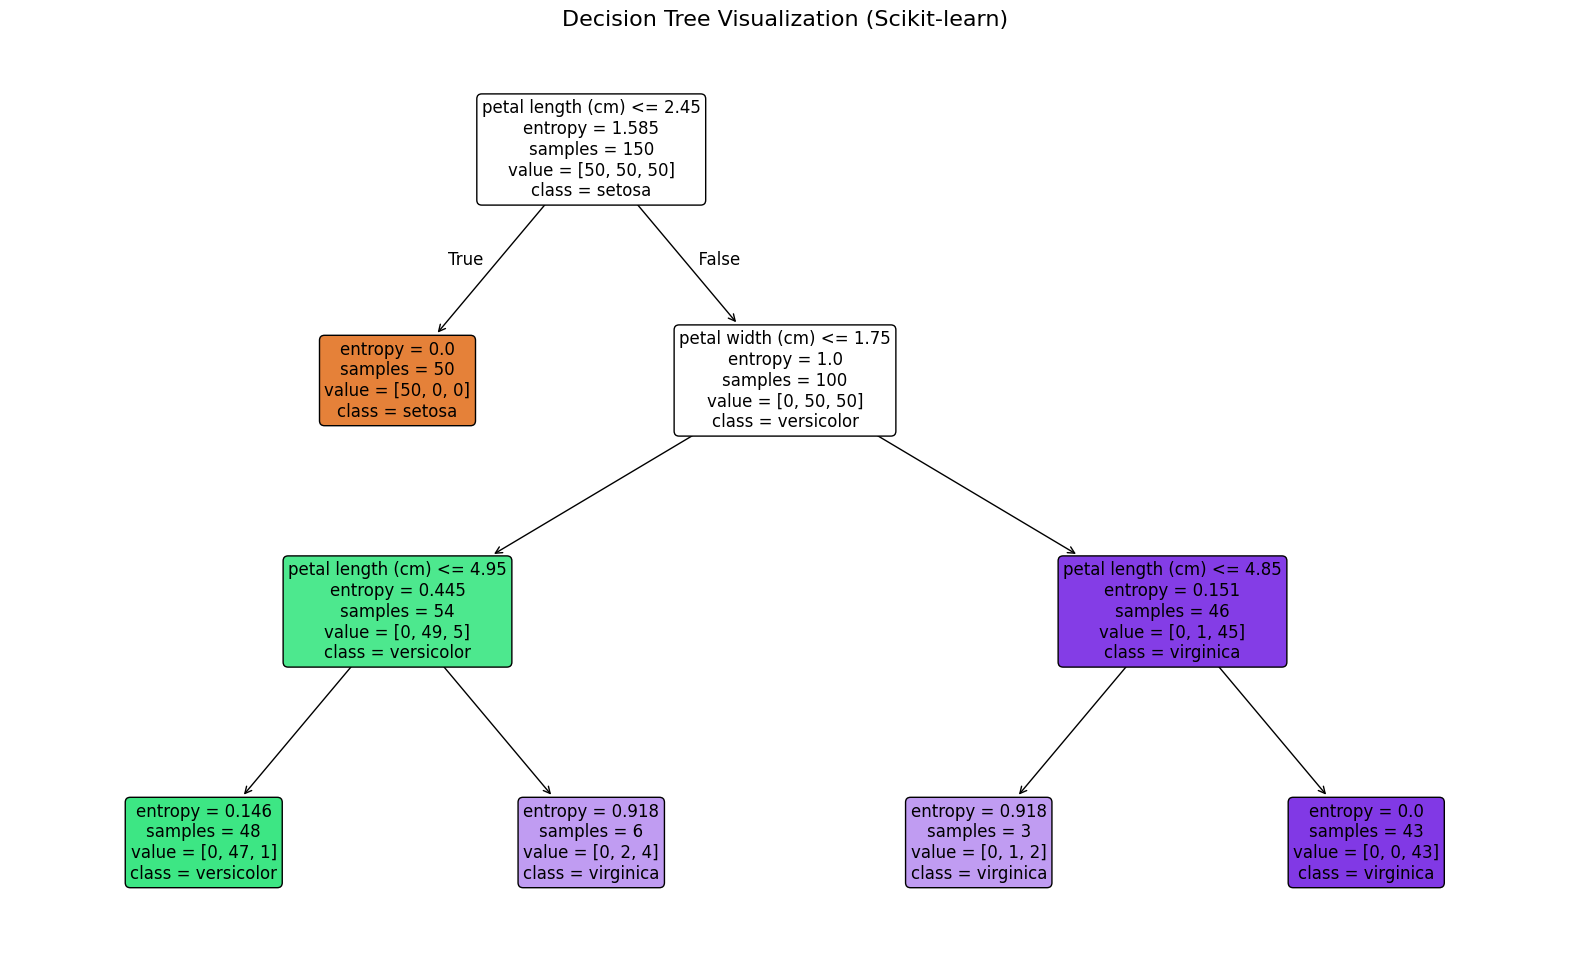


--- Task A7: Visualizing the Decision Boundary ---
A plot window will now open showing the decision boundary...


C:\Users\nikhi\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


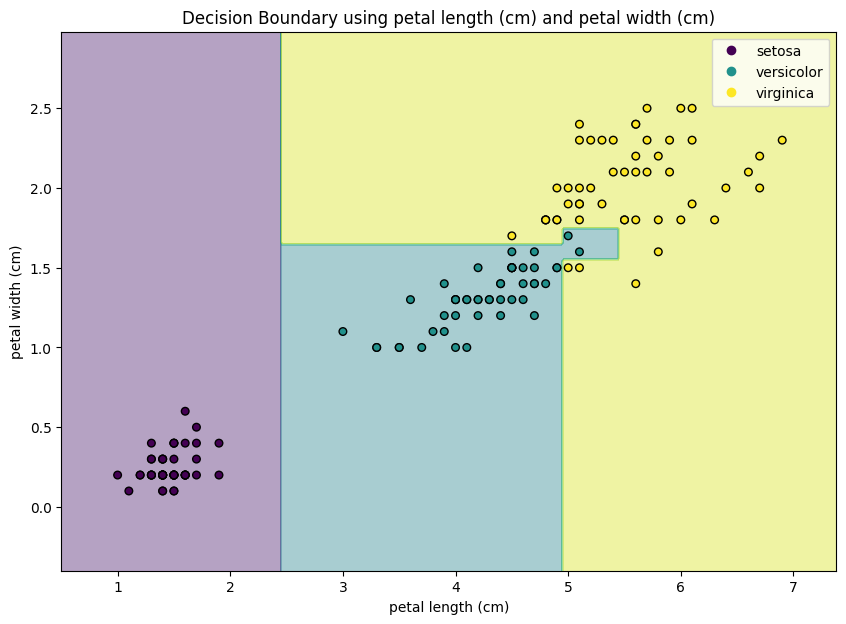


--- End of Analysis ---


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier, plot_tree
import json

# --- Helper Functions (used by main task functions) ---

def flexible_binning(feature_data, n_bins=4, bin_type='equal_width'):
    """
    (Helper for A4) Converts a continuous feature into discrete bins.
    The binning type and number of bins are passed as parameters.
    """
    if bin_type == 'equal_width':
        # Employs equal width binning.
        return pd.cut(feature_data, bins=n_bins, labels=[f'W_Bin_{i+1}' for i in range(n_bins)], include_lowest=True)
    elif bin_type == 'equal_frequency':
        # Employs equal frequency binning.
        # 'duplicates=drop' handles cases where bin edges are not unique.
        return pd.qcut(feature_data, q=n_bins, labels=[f'F_Bin_{i+1}' for i in range(n_bins)], duplicates='drop')
    else:
        raise ValueError("bin_type must be 'equal_width' or 'equal_frequency'")

def calculate_information_gain(df, feature_name, target_name, parent_entropy):
    """
    (Helper for A3) Calculates the information gain for a given feature.
    """
    # Group by the feature's values
    feature_values = df[feature_name].unique()
    weighted_child_entropy = 0
    
    for value in feature_values:
        subset = df[df[feature_name] == value]
        if len(subset) == 0:
            continue
        weight = len(subset) / len(df)
        child_entropy = task_1_calculate_entropy(subset[target_name])
        weighted_child_entropy += weight * child_entropy
        
    information_gain = parent_entropy - weighted_child_entropy
    return information_gain
    
# --- Main Task Functions (A1-A7) ---

def task_1_calculate_entropy(y):
    """
    A1. Calculates the entropy associated with the dataset's target variable.
    Implements the formula H = -sum(p_i * log2(p_i)).
    """
    class_counts = y.value_counts()
    probabilities = class_counts / len(y)
    # Filter out probabilities of 0 to avoid log2(0)
    probabilities = probabilities[probabilities > 0]
    entropy = -np.sum(probabilities * np.log2(probabilities))
    return entropy

def task_2_calculate_gini_index(y):
    """
    A2. Calculates the Gini index value for the dataset's target variable.
    Implements the formula Gini = 1 - sum(p_j^2).
    """
    class_counts = y.value_counts()
    probabilities = class_counts / len(y)
    gini_index = 1 - np.sum(probabilities**2)
    return gini_index

def task_3_and_4_find_root_node(X, y):
    """
    A3 & A4. Detects the feature for the root node of a Decision Tree.
    Uses Information Gain as the impurity measure.
    Converts continuous features to categorical using binning.
    """
    best_feature = None
    max_ig = -1
    
    parent_entropy = task_1_calculate_entropy(y)
    df = pd.concat([X, y], axis=1)
    
    # Store IG for each feature to find the max
    gains = {}
    for feature in X.columns:
        binned_feature = flexible_binning(X[feature], n_bins=4, bin_type='equal_frequency')
        temp_df = df.copy()
        temp_df[feature] = binned_feature
        
        ig = calculate_information_gain(temp_df, feature, y.name, parent_entropy)
        gains[feature] = ig
    
    # Find the best feature from the calculated gains
    if gains:
        best_feature = max(gains, key=gains.get)
        max_ig = gains[best_feature]
            
    return best_feature, max_ig

def task_5_build_decision_tree(X, y, current_depth=0, max_depth=3):
    """
    A5. Expands the above functions to build a Decision Tree module (simplified).
    This function recursively builds a tree as a nested dictionary.
    """
    # Base cases for recursion
    # 1. If node is pure (all labels are the same)
    if len(y.unique()) == 1:
        # FIX: Convert numpy.int64 to a standard Python int for JSON serialization
        return int(y.iloc[0])
    # 2. If there are no features left to split on
    if len(X.columns) == 0:
        return int(y.mode()[0])
    # 3. If max depth is reached
    if current_depth >= max_depth:
        return int(y.mode()[0])

    # Find the best feature to split on
    best_feature, _ = task_3_and_4_find_root_node(X, y)
    
    if best_feature is None:
        return int(y.mode()[0])

    # Create the tree node
    tree = {best_feature: {}}
    
    # Bin the best feature to create discrete branches
    binned_values = flexible_binning(X[best_feature], n_bins=4, bin_type='equal_frequency')
    
    for value in binned_values.cat.categories:
        indices = binned_values == value
        sub_X = X.loc[indices].drop(columns=[best_feature])
        sub_y = y.loc[indices]
        
        if len(sub_y) == 0:
            tree[best_feature][str(value)] = int(y.mode()[0])
        else:
            subtree = task_5_build_decision_tree(sub_X, sub_y, current_depth + 1, max_depth)
            tree[best_feature][str(value)] = subtree
            
    return tree

def task_6_visualize_sklearn_tree(X, y, feature_names, class_names):
    """
    A6. Draws and visualizes the decision tree constructed based on the data.
    Uses scikit-learn for robust implementation and visualization.
    """
    dt_classifier = DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=3)
    dt_classifier.fit(X, y)
    
    plt.figure(figsize=(20, 12))
    plot_tree(
        dt_classifier,
        feature_names=feature_names,
        class_names=class_names,
        filled=True,
        rounded=True,
        fontsize=12
    )
    plt.title("Decision Tree Visualization (Scikit-learn)", fontsize=16)
    plt.show()

def task_7_visualize_decision_boundary(X, y, feature_names, class_names):
    """
    A7. Uses 2 features from the dataset to visualize the decision boundary.
    """
    X_2_features = X.iloc[:, [2, 3]] # Using petal length and petal width for better separation
    
    dt_boundary_clf = DecisionTreeClassifier(criterion='entropy', random_state=42)
    dt_boundary_clf.fit(X_2_features, y)
    
    x_min, x_max = X_2_features.iloc[:, 0].min() - 0.5, X_2_features.iloc[:, 0].max() + 0.5
    y_min, y_max = X_2_features.iloc[:, 1].min() - 0.5, X_2_features.iloc[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
    
    Z = dt_boundary_clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(10, 7))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap='viridis')
    scatter = plt.scatter(X_2_features.iloc[:, 0], X_2_features.iloc[:, 1], c=y, s=30, edgecolor='k', cmap='viridis')
    plt.title(f'Decision Boundary using {X_2_features.columns[0]} and {X_2_features.columns[1]}')
    plt.xlabel(X_2_features.columns[0])
    plt.ylabel(X_2_features.columns[1])
    plt.legend(handles=scatter.legend_elements()[0], labels=class_names)
    plt.show()

if __name__ == '__main__':
    iris = load_iris()
    X = pd.DataFrame(iris.data, columns=iris.feature_names)
    y = pd.Series(iris.target, name='species')
    class_names = list(iris.target_names)
    
    print("--- Lab 06: Decision Tree on Iris Dataset ---")

    # --- A1: Entropy ---
    print("\n--- Task A1: Entropy Calculation ---")
    entropy_val = task_1_calculate_entropy(y)
    print(f"Entropy of the Iris dataset target: {entropy_val:.4f}")

    # --- A2: Gini Index ---
    print("\n--- Task A2: Gini Index Calculation ---")
    gini_val = task_2_calculate_gini_index(y)
    print(f"Gini index of the Iris dataset target: {gini_val:.4f}")

    # --- A3 & A4: Find Root Node ---
    print("\n--- Task A3 & A4: Find Root Node using Information Gain ---")
    print("Calculating Information Gain for each feature...")
    root_feature, max_gain = task_3_and_4_find_root_node(X, y)
    print(f"==> Best feature for root node: '{root_feature}' (IG: {max_gain:.4f})")

    # --- A5: Build Custom Tree ---
    print("\n--- Task A5: Build a Simplified Decision Tree (Conceptual) ---")
    custom_tree = task_5_build_decision_tree(X, y, max_depth=2)
    print("Custom-built tree structure (as a nested dictionary):")
    print(json.dumps(custom_tree, indent=2))
    print("(Note: Integers 0, 1, 2 represent classes 'setosa', 'versicolor', 'virginica')")

    # --- A6: Visualize Sklearn Tree ---
    print("\n--- Task A6: Visualizing the Decision Tree (Scikit-learn) ---")
    print("A plot window will now open showing the trained decision tree...")
    task_6_visualize_sklearn_tree(X, y, iris.feature_names, class_names)

    # --- A7: Visualize Decision Boundary ---
    print("\n--- Task A7: Visualizing the Decision Boundary ---")
    print("A plot window will now open showing the decision boundary...")
    task_7_visualize_decision_boundary(X, y, iris.feature_names, class_names)
    
    print("\n--- End of Analysis ---")